# Setup environment

## Install Open FUSION Toolkit and add to path
To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [1]:
import os
import sys
try:
    import google.colab
except:
    tokamaker_python_path = os.getenv('OFT_ROOTPATH')
    if tokamaker_python_path is not None:
        sys.path.append(os.path.join(tokamaker_python_path,'python'))
    %matplotlib inline
    pass
else:
    !pip install triangle wurlitzer ipympl
    OFT_package = 'OpenFUSIONToolkit_v1.0.0-beta4-Linux-GNU-x86_64'
    OFT_tarball = 'OpenFUSIONToolkit_v1.0.0-beta4-Ubuntu_20_04-GNU-x86_64.tar.gz'
    if not os.path.exists(os.path.join('/content',OFT_package,'python')):
        !wget https://github.com/hansec/OpenFUSIONToolkit/releases/download/v1.0.0-beta4/{OFT_tarball}
        !tar xzf {OFT_tarball}
    OFT_rootpath = os.path.join('/content',OFT_package)
    sys.path.append(os.path.join(OFT_rootpath,'python'))
    %load_ext wurlitzer
    %matplotlib ipympl

## Load other Python packages



In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# Computing equilbria with a known boundary

## Load TokaMaker objects from OFT
For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [3]:
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk, create_power_flux_fun
from OpenFUSIONToolkit.util import mu0

## Create mesh
First we define a target size to set the resolution in our grid. This variable will be used later and represent the target edge size within our mesh, where units are in meters. In this case we are using a fairly coarse resolution of 1.5 cm (10 radial points). Note that when setting up a new machine these values will need to scale with the overall size of the device/domain. It is generally a good idea perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions, when working with a new geometry to ensure the results are not sensitive to your choice of grid size.

### Define boundary
For this example we will first generate a mesh for fixed-boundary calculation using the simple flux surface definition in \ref OpenFUSIONToolkit.TokaMaker.create_isoflux "create_isoflux". This function parameterizes a surface using a center point (R,Z), minor radius (a), and elongation and triangularity, which can can optionally have different upper and lower value. For this case we make a plasma comparable to those generated in the LTX-$\beta$ device at the Princeton Plasma Physics Laboratory.

In [4]:
mesh_dx = 0.1
R0_target = 6.3
Z0_target = 0.5
a_target = 2.0
kappa_target = 1.0
delta_target = 0.0
LCFS_contour = create_isoflux(40,R0_target,Z0_target,a_target,kappa_target,delta_target)

### Define regions and attributes
We now create the mesh object and define the various logical mesh regions. In this case we only have one region, which is named `plasma` and is of type `plasma`. See other examples for more complex cases with other region types.

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',mesh_dx,'plasma')

### Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.

In [6]:
gs_mesh.add_polygon(LCFS_contour,'plasma')

### Generate mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh" method. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [7]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()

Assembling regions:
  # of unique points    = 125
  # of unique segments  = 1
Generating mesh:
  # of points  = 1988
  # of cells   = 3849
  # of regions = 1


### Plot resulting regions and grid
We now plot the mesh to inspect proper generation.

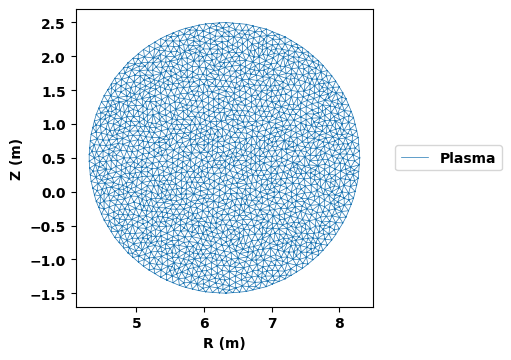

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [9]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_power_flux_fun
Revision id:          e06699b
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated above using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh" and set the code to operate in fixed boundary mode by setting the `free_boundary` setting to False. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [10]:
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.setup(order=2, F0=5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.251E+01
    # of points  =    1988
    # of edges   =    5836
    # of cells   =    3849
    # of boundary points =     125
    # of boundary edges  =     125
    # of boundary cells  =     125
  Resolution statistics:
    hmin =  6.208E-02
    hrms =  9.108E-02
    hmax =  1.476E-01
  Surface grounded at vertex      66


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1



### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

In [11]:
Ip_target=2.0E6
P0_target=4.E4
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

**Note:** More tools to aide in setting these profiles are coming soon

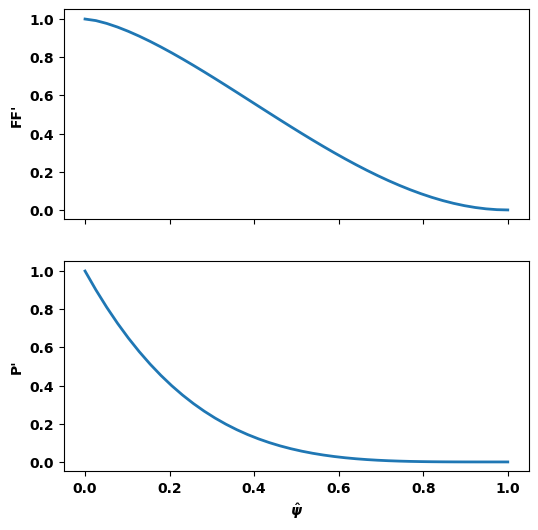

In [12]:
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,1.0,4.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Initialize the flux function
Before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". By default this calculation uses a uniform current (equal to Ip_target) over the full plasma domain. Additional options are also availble to tailor this distribution for more control.

In [13]:
err_flag = mygs.init_psi()

### Compute a fixed-boundary equilibrium
Now we can compute an equilibrium in this geometry using the default profiles for F*F' and P' by running \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve".

In [14]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1 -1.3603E+00  1.9725E-01  2.1398E-02  6.6069E+00  5.0004E-01  0.0000E+00
     2  6.1804E+00  8.9786E-02  1.6340E-03  6.5958E+00  5.0008E-01  0.0000E+00
     3  6.2281E+00  8.8007E-02  1.0927E-03  6.5840E+00  5.0016E-01  0.0000E+00
     4  6.1844E+00  8.8063E-02  7.7406E-04  6.5738E+00  5.0008E-01  0.0000E+00
     5  6.1537E+00  8.8229E-02  5.5448E-04  6.5660E+00  5.0002E-01  0.0000E+00
     6  6.1362E+00  8.8336E-02  3.9872E-04  6.5602E+00  4.9999E-01  0.0000E+00
     7  6.1260E+00  8.8399E-02  2.8681E-04  6.5559E+00  4.9996E-01  0.0000E+00
     8  6.1194E+00  8.8440E-02  2.0627E-04  6.5528E+00  4.9995E-01  0.0000E+00
     9  6.1149E+00  8.8467E-02  1.4833E-04  6.5506E+00  4.9994E-01  0.0000E+00
    10  6.1118E+00  8.8486E-02  1.0663E-04  6.5490E+00  4.9994E-01  0.0000E+00
    11  6.1096E+00  8.8500E-02  7.6634E-05  6.5478E+00  4.9993E-01  0.0000E+00
    12  6.1080E+00  8.8510E-02  5.5078E-05  6.5470E+00  4.9993E-01  0.0000E+00
    13  6.1068E+00  8.

### Print information and plot equilibrium
After computing the equilibrium, basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

Flux surfaces can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. Additional plotting methods are also available to display other information for more complex cases. See other examples and the documentation for more information.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    2.0000E+06
  Current Centroid [m]    =    6.425  0.500
  Magnetic Axis [m]       =    6.545  0.500
  Elongation              =    1.001 (U:  1.001, L:  1.000)
  Triangularity           =    0.000 (U: -0.001, L:  0.002)
  Plasma Volume [m^3]     =   495.180
  q_0, q_95               =    1.510  8.268
  Peak Pressure [Pa]      =    3.9801E+04
  Stored Energy [J]       =    2.6040E+06
  <Beta_pol> [%]          =   21.4213
  <Beta_tor> [%]          =    0.0337
  Diamagnetic flux [Wb]   =    3.7840E-02
  Toroidal flux [Wb]      =    6.7010E+01
  l_i                     =    1.5122


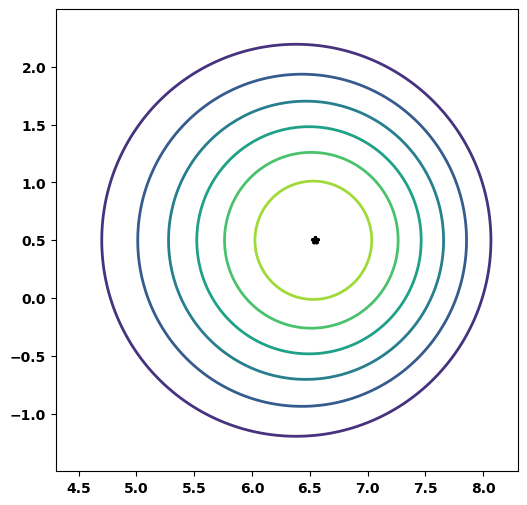

In [15]:
mygs.print_info()
# Plot flux surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

In [16]:
mygs.settings.pm=False
mygs.update_settings()

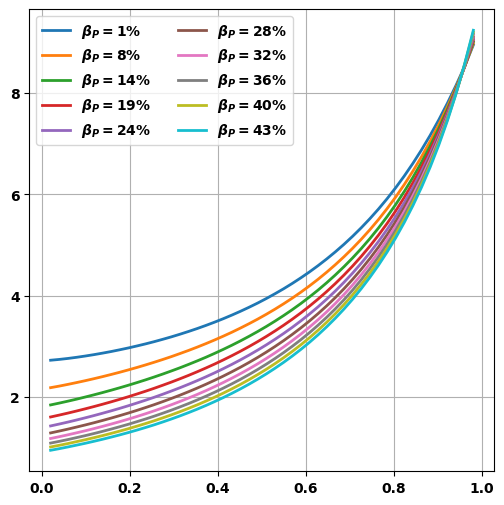

In [17]:
q_fig, q_ax = plt.subplots(1,1)
for P0_target_tmp in np.linspace(1.E3,1.E5,10):
    mygs.set_targets(Ip=Ip_target, pax=P0_target_tmp)
    err_flag = mygs.solve()
    #
    stats_dict = mygs.get_stats()
    psi_q,qvals,_,_,_,_ = mygs.get_q()
    q_ax.plot(psi_q,qvals,label=r'$\beta_P = {0:.0f}\%$'.format(stats_dict['beta_pol']))
q_ax.grid(True)
q_ax.legend(ncols=2)

## Change the parameters yourself

 * What is the maximum plasma current you can get with $q_{max} > 1$?
 * How does this change with the shape of the profiles?